# LLM from scratch

Credits: a lot of the code is inspired from Andrej Karpathy's lectures, videos, and repositories, in particular
https://github.com/karpathy/nn-zero-to-hero
https://github.com/karpathy/makemore

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import trange

What we will do here: train a generative model with all lyrics of Eminem.
The goal is to generate Eminem-like songs!

In [2]:
# hyperparameters
n_token = 4096
batch_size = 16 # number of sequences processed in parallel
block_size = 8 # maximum context length for predictions
max_iters = 5000
eval_interval = 200
learning_rate = 1e-3
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4

## Part 1: Playing with the dataset

In [ ]:
# Let's download all of Eminem's lyrics
!wget https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/eminem.txt

In [3]:
with open('eminem.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
data_size = len(text)
data_size

1701158

In [5]:
print(text[:1000])

look i was gonna go easy on you not to hurt your feelings but i'm only going to get this one chance six minutes six minutes something's wrong i can feel it six minutes slim shady you're on just a feeling i've got like something's about to happen but i don't know what  if that means what i think it means we're in trouble big trouble  and if he is as bananas as you say i'm not taking any chances you are just what the doc ordered   i'm beginnin' to feel like a rap god rap god all my people from the front to the back nod back nod now who thinks their arms are long enough to slap box slap box they said i rap like a robot so call me rapbot   but for me to rap like a computer it must be in my genes i got a laptop in my back pocket my pen'll go off when i halfcock it got a fat knot from that rap profit made a livin' and a killin' off it ever since bill clinton was still in office with monica lewinsky feelin' on his nutsack i'm an mc still as honest but as rude and as indecent as all hell sylla

We will start with a basic character-level tokenizer

In [6]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(itos)

{0: '\n', 1: ' ', 2: "'", 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z'}


In [7]:
test = "hello world"
test_encoded = encode(test)
test_encoded, decode(test_encoded)

([10, 7, 14, 14, 17, 1, 25, 17, 20, 14, 6], 'hello world')

In [8]:
test_encoded = torch.tensor(test_encoded)
test_tensor = F.one_hot(test_encoded, num_classes=vocab_size).float()
test_tensor, test_tensor.shape

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.,

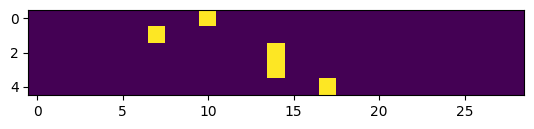

In [9]:
# The first 5 characters code for "hello"
plt.imshow(test_tensor[:5]);

## Part 2: Bigram model

This is boilerplate code! Since this is still a warm-up we're not doing batches.

In [10]:
data = torch.tensor(encode(text))
# print(data.shape)

def get_data():
    i = torch.randint(data_size - 1, (1,))
    x = F.one_hot(data[i], num_classes=vocab_size).float()
    y = F.one_hot(data[i+1], num_classes=vocab_size).float()
    return x,y
        
@torch.no_grad()
def estimate_loss_no_batch(model):
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_data()
            logits, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

get_data()

(tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [11]:
def train_no_batch(model, max_iters = max_iters, eval_interval = eval_interval, learning_rate = learning_rate):
    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(max_iters):
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss_no_batch(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample data
        x,y = get_data()

        # evaluate the loss
        logits, loss = model(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

In [12]:
# Illustration of cross entropy loss
number_classes_test = 5

inpt = torch.randn(number_classes_test)
print("input: \n", inpt)
inpt_exped = inpt.exp()
print("after exponentiation: \n", inpt_exped)
probs = inpt_exped / inpt_exped.sum()
print("after normalisation: \n", probs)
logprobs = -probs.log()
print("we work with log probabilities: \n", logprobs)

target = torch.randint(number_classes_test, (), dtype=torch.int64)
print("target: ", target.item())

loss = F.cross_entropy(inpt, target)
print("loss: ", loss.item())

input: 
 tensor([-0.8787,  1.5182,  0.3445, -0.9478,  0.8676])
after exponentiation: 
 tensor([0.4153, 4.5642, 1.4113, 0.3876, 2.3812])
after normalisation: 
 tensor([0.0453, 0.4983, 0.1541, 0.0423, 0.2600])
we work with log probabilities: 
 tensor([3.0935, 0.6966, 1.8703, 3.1626, 1.3472])
target:  1
loss:  0.6965652704238892


And now the same but with batching:

In [13]:
batch_size_test = 3
number_classes_test = 5

inpt = torch.randn(batch_size_test, number_classes_test)
target = torch.randint(number_classes_test, (batch_size_test,), dtype=torch.int64)
loss = F.cross_entropy(inpt, target)
print("input: ", inpt, "\ntarget: ", target, "\nloss: ", loss.item())

input:  tensor([[ 1.5327,  0.7377,  0.4508, -0.8066, -0.2595],
        [-1.0268,  0.1533, -2.2826,  0.3533, -0.6487],
        [ 1.0009,  0.7900,  1.1514,  0.4492, -0.8628]]) 
target:  tensor([0, 0, 1]) 
loss:  1.513232707977295


In [14]:
class Bigram(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(torch.zeros((vocab_size, vocab_size)))

    def forward(self, x, targets=None):
        logits = x @ self.W
        
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets) + 0.1 * (self.W**2).mean()

        return logits, loss    

In [15]:
model = Bigram()
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters()), ' parameters')

841  parameters


In [16]:
def generate_bigram(model, max_new_tokens = 200):
    idx = F.one_hot(torch.tensor(stoi["\n"]), num_classes=vocab_size).float()
    out = []
    for _ in range(max_new_tokens):
        # get the predictions
        logits, loss = model(idx)
        # logits = (vocab_size)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=0) # (vocab_size)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1) # (1)
        # append sampled index to the output sequence
        out.append(idx_next.item())
        idx = F.one_hot(idx_next.view(()), num_classes=vocab_size).float()

    return decode(out)

In [17]:
torch.manual_seed(1337)

print(generate_bigram(model))

tprmeoqjgxr bvfbhpfmujhlvkz wzelbjk jk cqyk
czou

aqfqevvndfiwgsmrwsxsttwa
ofyrn lsi lucwghkozio
tfzqcywfy
wpzu'hgflzw
v'unv'fvjcgkvyplvs' wxxydf'sfaendfcvyqw
ypjmaha hoal
twymmur'tuhepf fexhaglgfbr s


In [18]:
torch.manual_seed(1337)

train_no_batch(model, eval_interval = 1000, learning_rate = 2e-2)

step 0: train loss 3.3673, val loss 3.3673
step 1000: train loss 2.7939, val loss 2.8962
step 2000: train loss 2.7827, val loss 2.7711
step 3000: train loss 2.7303, val loss 2.8689
step 4000: train loss 2.7596, val loss 2.6431
step 4999: train loss 2.6806, val loss 2.6151


In [19]:
torch.manual_seed(1337)

print(generate_bigram(model))

thome qjg llbafbhabmuju ikz whelema ju tayk
czou

aqf eve d i ghmawhxstowat aybn loi lucwgh ozis
t kecywitiwlou'hg l whedunond jcy fuplest whe di's ated t yqw
yoonaha healat ymm retale f fee aglaser s


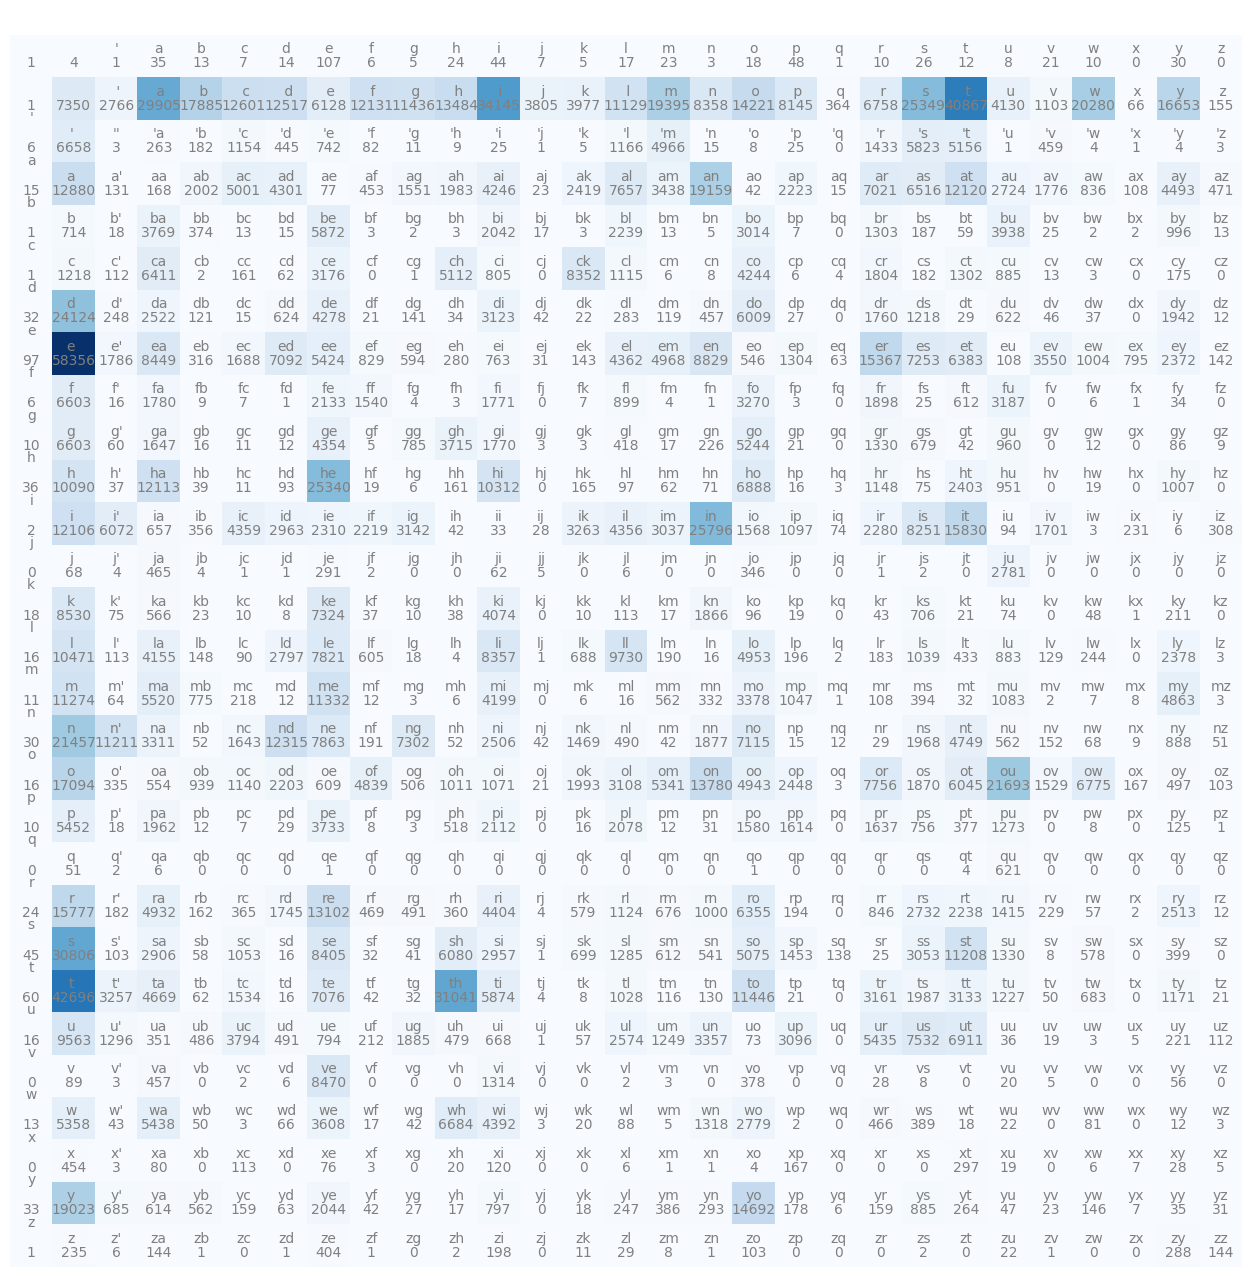

In [20]:
N = torch.zeros((vocab_size, vocab_size), dtype=torch.int32)

for i in range(len(text) - 1):
    N[stoi[text[i]], stoi[text[i+1]]] += 1
    
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

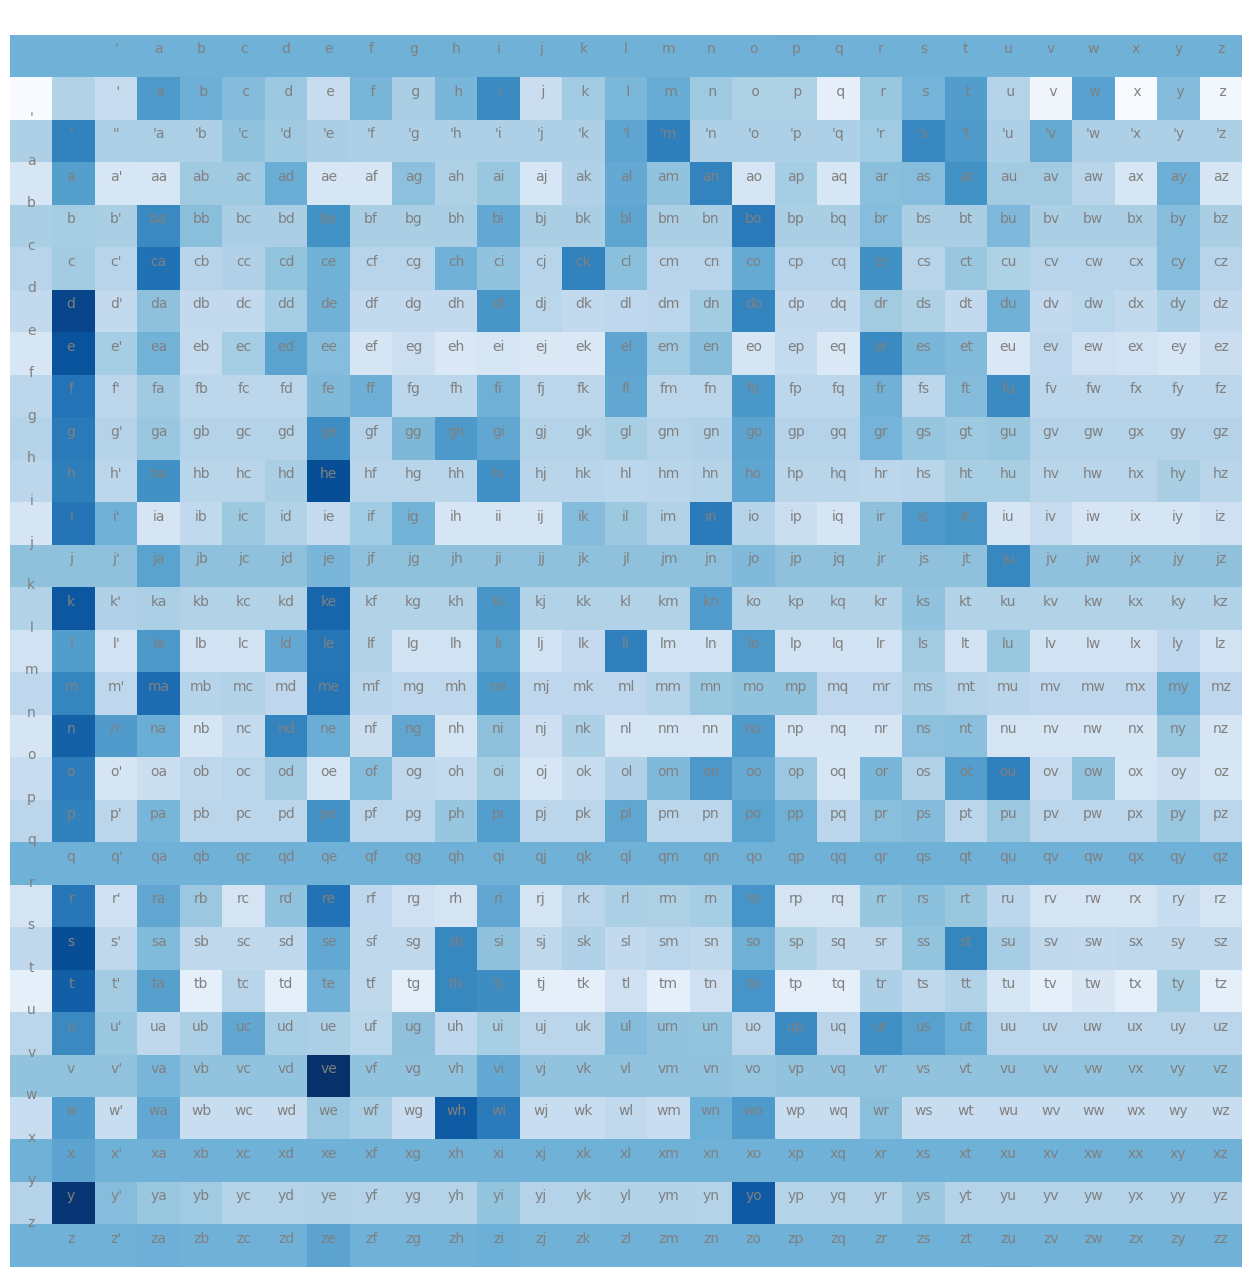

In [21]:
@torch.no_grad()
def plot_W(model):
    plt.figure(figsize=(16,16))
    plt.imshow(model.W, cmap='Blues')
    for i in range(vocab_size):
        for j in range(vocab_size):
            chstr = itos[i] + itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
    plt.axis('off');
    
plot_W(model)

A more Pytorch-friendly way of writing a bigram model:

In [22]:
class BigramProper(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Linear(vocab_size, vocab_size, bias=False)

    def forward(self, x, targets=None):
        logits = self.net(x)
        
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets) + 0.1 * (self.net.weight**2).mean()

        return logits, loss    

In [23]:
model = BigramProper()
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters()), ' parameters')

torch.manual_seed(1337)

train_no_batch(model, max_iters = 5000, learning_rate = 2e-2)
print("\n", generate_bigram(model))

841  parameters
step 0: train loss 3.3552, val loss 3.3689
step 200: train loss 3.1301, val loss 3.1483
step 400: train loss 2.9354, val loss 2.9857
step 600: train loss 2.9170, val loss 2.8654
step 800: train loss 2.8541, val loss 2.8421
step 1000: train loss 2.8752, val loss 2.8263
step 1200: train loss 2.7212, val loss 2.6972
step 1400: train loss 2.7971, val loss 2.9200
step 1600: train loss 2.7101, val loss 2.8268
step 1800: train loss 2.7755, val loss 2.7950
step 2000: train loss 2.8506, val loss 2.7526
step 2200: train loss 2.7284, val loss 2.6601
step 2400: train loss 2.6690, val loss 2.7129
step 2600: train loss 2.6634, val loss 2.7674
step 2800: train loss 2.7719, val loss 2.6503
step 3000: train loss 2.7298, val loss 2.6752
step 3200: train loss 2.6887, val loss 2.7601
step 3400: train loss 2.6490, val loss 2.6668
step 3600: train loss 2.5429, val loss 2.8326
step 3800: train loss 2.5790, val loss 2.7043
step 4000: train loss 2.6788, val loss 2.7371
step 4200: train loss 2.6

## Part 3: Word-level tokenizer

We use `minbpe`, which implements the Byte Pair Encoding (BPE) algorithm commonly used in LLM tokenization.

In [24]:
from minbpe.minbpe import RegexTokenizer

In [ ]:
# The tokenizer takes a while to run so let's download a tokenizer
!wget https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/tok4k.model
!wget https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/tok4k.vocab

In [25]:
tokenizer = RegexTokenizer()
tokenizer.load("tok4k.model") # loads the model back from disk
n_token = 4096

In [26]:
# we encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:50])

torch.Size([450310]) torch.int64
tensor([2518,  257,  393,  509,  369, 2519,  317,  270,  390,  281,  734,  341,
        2240,  334,  257,  303,  624, 2016,  281,  365,  347,  474, 1215, 1727,
        2017, 1727, 2017, 1074,  296, 1362,  257,  372,  465,  291, 1727, 2017,
         589,  518,  270,  408,  317,  336,  258, 2018,  257,  586,  400,  337,
        1074,  296])


In [27]:
test = "hello world"
test_encoded = tokenizer.encode(test)
test_encoded, [tokenizer.decode([x]) for x in test_encoded], tokenizer.decode(test_encoded)

([104, 472, 111, 651], ['h', 'ell', 'o', ' world'], 'hello world')

NSFW!

In [28]:
token_list = sorted([tokenizer.decode([x]) for x in range(4096)], key=len, reverse=True)
token_list[:20]

[' motherfuckers',
 ' motherfucking',
 ' entertainment',
 ' oohoohoohooh',
 ' motherfuckin',
 ' motherfucker',
 ' relationship',
 ' neighborhood',
 ' blockbusters',
 ' oohoohoohoo',
 ' opportunity',
 ' controversy',
 ' underground',
 ' mothafuckin',
 ' competition',
 ' wifebeaters',
 ' differently',
 ' immediately',
 ' practically',
 ' recognition']

In [29]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

## Part 4: Evaluating and training with batches

Now this is boilerplate code for models with batching and fixed blocks as context:

In [30]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    X = torch.stack([data[i:i+block_size] for i in ix])
    Y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    # X,Y (batch_size, block_size)
    return X, Y 

In [31]:
X, Y = get_batch('train')
print('inputs:')
print(X)
print(X.shape)
print('targets:')
print(Y)
print(Y.shape)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = X[b, :t+1]
        target = Y[b,t]
        print(f"when the input is {context.tolist()}, the target is: {target}")

inputs:
tensor([[ 257,  412,  321,  266,  744, 1866, 2468,  336],
        [ 520,  423,  328,  506,  520,  973, 1823,   98],
        [ 121,  820,  115,  368,  347, 1453,  347, 1130],
        [ 384,  509,  801,  328,  338,  429,  257,  427],
        [ 296, 1423,  291,  328,  402,  604,  387, 3156],
        [ 361,  270, 1410,  270, 1359,  859,  814,  309],
        [ 368, 1643, 3144, 1146,  115,  257, 1164,  337],
        [ 257,  303, 1726,  291,  455,  447,  268, 1381],
        [3541, 2084,  365,  268,  364, 1223,  569,  343],
        [ 299, 1288,  257,  620,  111, 2973,  285,  270],
        [ 317,  891,   39,  281,  530,  258,  760,  779],
        [ 569,  281, 2906,  257,  702,  312,  268,  474],
        [ 372, 3136,  305,  341,  266,  542,  270,  372],
        [ 384, 2077,  357, 1185, 1749,  292,  765, 1232],
        [ 885,  269, 1461,  281, 1729,  304,  285,  561],
        [ 291, 1055,  258,  609, 1074,  337, 1090,  121]])
torch.Size([16, 8])
targets:
tensor([[ 412,  321,  266,  744, 1

In [32]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [33]:
def train(model, max_iters = max_iters, learning_rate = learning_rate):
    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(max_iters):
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample batch
        X,Y = get_batch("train")

        # evaluate the loss
        logits, loss = model(X, Y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

In [34]:
def generate(model, max_new_tokens = 2000):
    idx = torch.zeros((1,block_size), dtype=torch.long) 
    # idx (1,block_size)
    for _ in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        # forward the model to get the logits for the index in the sequence
        logits, _ = model(idx_cond)
        # pluck the logits at the final step
        logits = logits[:, -1, :]
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)
    return tokenizer.decode(idx[0][block_size:].tolist())

## Part 5: A Multi Layer Perceptron (MLP) model

In [35]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # We add a special <BLANK> token  (explaining the + 1)
        self.token_embedding_table = nn.Embedding(n_token + 1, n_embd)
        self.net = nn.Sequential(
            nn.Linear(block_size * n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_token)
        )

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # B = either batch_size or 1
        # T = block_size

        embs = []
        for _ in range(block_size):
            tok_emb = self.token_embedding_table(idx) # (B, block_size, n_embd)
            idx = torch.roll(idx, 1, 1)
            idx[:, 0] = vocab_size # special <BLANK> token
            embs.append(tok_emb)

        # concat all of the embeddings together
        x = torch.cat(embs, -1) # (B, block_size, n_embd * block_size)
        logits = self.net(x) # (B, block_size, n_token)
        
        if targets is None:
            loss = None
        else:
            # targets (B, T)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss    

In [36]:
model = MLP()

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

1.446208  M parameters


In [37]:
torch.manual_seed(1330)

generate(model, max_new_tokens = 20)

'etic bull on bedrid punch chkach criminal subl deadly quitste bor mouth thinks hurl everything tried minute ruined maxi'

In [38]:
torch.manual_seed(1330)

train(model)

step 0: train loss 8.3581, val loss 8.3555
step 200: train loss 6.3706, val loss 6.3791
step 400: train loss 6.2089, val loss 6.2430
step 600: train loss 6.0714, val loss 6.1573
step 800: train loss 5.9681, val loss 6.0793
step 1000: train loss 5.8927, val loss 5.9785
step 1200: train loss 5.7931, val loss 5.9087
step 1400: train loss 5.7390, val loss 5.8237
step 1600: train loss 5.6378, val loss 5.7798
step 1800: train loss 5.5970, val loss 5.7274
step 2000: train loss 5.4811, val loss 5.6544
step 2200: train loss 5.4129, val loss 5.5989
step 2400: train loss 5.3866, val loss 5.5773
step 2600: train loss 5.3556, val loss 5.5275
step 2800: train loss 5.2727, val loss 5.4382
step 3000: train loss 5.2303, val loss 5.4499
step 3200: train loss 5.1791, val loss 5.3974
step 3400: train loss 5.1510, val loss 5.3569
step 3600: train loss 5.1012, val loss 5.3408
step 3800: train loss 5.0859, val loss 5.3245
step 4000: train loss 5.0341, val loss 5.2221
step 4200: train loss 4.9998, val loss 5.

In [39]:
torch.manual_seed(1337)

generate(model, max_new_tokens = 50)

" is what i did is then mass away a magic inch but i here again of out life with kate shit man i am on this fuckin' chargged their fans hope bitch the unce in the conoup like a river and you"

## Part 6: Attention mechanism

### Preliminary: an exercise in Pytorch programming

In [40]:
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)

print(x.shape, "\nx[0,:,:]:\n", x[0,:,:])

torch.Size([4, 8, 2]) 
x[0,:,:]:
 tensor([[ 1.3514, -0.2759],
        [-1.5108,  2.1048],
        [ 2.7630, -1.7465],
        [ 0.4109, -0.2422],
        [ 0.8212, -0.2115],
        [ 0.7789,  1.5333],
        [ 1.6097, -0.4032],
        [-0.2749,  1.4738]])


We want to compute 
$$x[b,t,c] = mean \left\{ x[b,i,c] : i \le t \right\}$$

**Version 1**: one should not write code like this in Pytorch!

In [41]:
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)
        
print("xbow[0,:,:]:\n", xbow[0,:,:])

xbow[0,:,:]:
 tensor([[ 1.3514, -0.2759],
        [-0.0797,  0.9144],
        [ 0.8678,  0.0274],
        [ 0.7536, -0.0400],
        [ 0.7671, -0.0743],
        [ 0.7691,  0.1936],
        [ 0.8892,  0.1084],
        [ 0.7437,  0.2791]])


**Version 2**: using matrix multiplication for a weighted aggregation

In [42]:
weights = torch.tril(torch.ones(T, T))
weights = weights / weights.sum(1, keepdim=True)
xbow2 = weights @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
print("xbow2[0,:,:]:\n", xbow2[0,:,:])

xbow2[0,:,:]:
 tensor([[ 1.3514, -0.2759],
        [-0.0797,  0.9144],
        [ 0.8678,  0.0274],
        [ 0.7536, -0.0400],
        [ 0.7671, -0.0743],
        [ 0.7691,  0.1936],
        [ 0.8892,  0.1084],
        [ 0.7437,  0.2791]])


**Version 3**: using softmax

In [44]:
tril = torch.tril(torch.ones(T, T))
weights = torch.zeros((T,T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)
xbow3 = weights @ x
print("xbow3[0,:,:]:\n", xbow2[0,:,:])

xbow3[0,:,:]:
 tensor([[ 1.3514, -0.2759],
        [-0.0797,  0.9144],
        [ 0.8678,  0.0274],
        [ 0.7536, -0.0400],
        [ 0.7671, -0.0743],
        [ 0.7691,  0.1936],
        [ 0.8892,  0.1084],
        [ 0.7437,  0.2791]])


### A self-attention head

Attention is a **communication mechanism**. It can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.

**Version 1**:
Every token emits two vectors of dimension C:
* a query: *describing the information I am looking for*
* a key: *describing the information I contain*

To determine the score (affinity) of a token for another one, we use dot-product of query times key. More general formulas could be used.

In [46]:
# Code for version 1
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, C) @ (B, C, 16) ---> (B, T, 16)
q = query(x) # (B, T, C) @ (B, C, 16) ---> (B, T, 16)
weights = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

out = weights @ x
out.shape

torch.Size([4, 8, 32])

In [47]:
weights[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0018, 0.9982, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9510, 0.0472, 0.0018, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0161, 0.1556, 0.0391, 0.7891, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1281, 0.1332, 0.0906, 0.5871, 0.0609, 0.0000, 0.0000, 0.0000],
        [0.0098, 0.0468, 0.4638, 0.0176, 0.4376, 0.0244, 0.0000, 0.0000],
        [0.4605, 0.1303, 0.0434, 0.0284, 0.0356, 0.2155, 0.0862, 0.0000],
        [0.3158, 0.0929, 0.0426, 0.0353, 0.0819, 0.1795, 0.1592, 0.0928]],
       grad_fn=<SelectBackward0>)

**Version 2**: 
Every token emits three vectors of dimension C:
* a query: *describing the information I am looking for*
* a key: *describing the information I contain*
* a value: *the information I reveal*

In [48]:
# Code for version 2
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
weights =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

v = value(x)
out = weights @ v
out.shape

torch.Size([4, 8, 16])

**Version 3**: 

There's one important issue: we need to renormalise, otherwise `q @ k` has large variance, and fed into the softmax it becomes almost a Dirac distribution. That's why we do "scaled attention": we additional divide `weights` by `1/sqrt(head_size)`. This makes it so when input `q,k` have unit variance, `weights` will have unit variance too and softmax will stay diffuse and not saturate too much. Illustrations below

In [49]:
x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
weights =  q @ k.transpose(-2, -1) # scaling: * head_size**-0.5

k.var(), q.var(), weights.var()

(tensor(0.3117, grad_fn=<VarBackward0>),
 tensor(0.3749, grad_fn=<VarBackward0>),
 tensor(1.9065, grad_fn=<VarBackward0>))

Illustration of `softmax` sensitivity to large numbers:

In [50]:
torch.softmax(torch.tensor([0.1, -0.2, -0.3, 0.2, 0.5]), dim=-1)

tensor([0.1997, 0.1479, 0.1338, 0.2207, 0.2979])

In [51]:
torch.softmax(torch.tensor([0.1, -0.2, -0.3, 0.2, 0.5])*10, dim=-1)

tensor([1.7128e-02, 8.5274e-04, 3.1371e-04, 4.6558e-02, 9.3515e-01])

In [53]:
# Code for version 3
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
weights =  q @ k.transpose(-2, -1) * head_size**-0.5 # (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

v = value(x)
out = weights @ v
out.shape

torch.Size([4, 8, 16])

**Of course**, each example across batch dimension is processed completely independently, they never "talk" to each other!

### Shall we?

In [54]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        # Some Pytorch way of defining a matrix without trainable parameters 
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))     

    def forward(self, x):
        B,T,C = x.shape
        # B = either batch_size or 1
        # T = block_size
        # C = head_size
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores (affinities)
        weights = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        weights = F.softmax(weights, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = weights @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

**Positional encoding**: There is no notion of space, the attention mechanism acts over a **set** of vectors. This is why we need to positionally encode tokens. Two solutions:
* Learning an embedding of positions
* Using a fixed embedding

Here we use the first solution but illustrate the second one below.

Suppose that the input representation $X \in \mathbb{R}^{n \times d}$ contains the $d$-dimensional embeddings for $n$ tokens of a sequence. 
The positional encoding outputs $X + P$ using a positional embedding matrix $P$ of the same shape, whose element on the $i$-th row and the $2j$-th or the $2j+1$-th column is
$$P(i,2j) = \text{sin}\left( \frac{i}{10000^{2j / d}} \right)$$
$$P(i,2j+1) = \text{cos}\left( \frac{i}{10000^{2j / d}} \right)$$

Credit for the code and picture: Jonathan Kernes, https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3

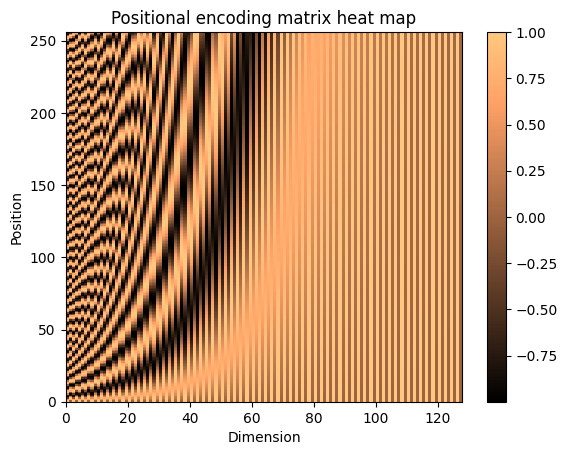

In [55]:
import numpy as np

def positional_encoding(max_position, d_model, min_freq=1e-4):
    position = np.arange(max_position)
    freqs = min_freq**(2*(np.arange(d_model)//2)/d_model)
    pos_enc = position.reshape(-1,1)*freqs.reshape(1,-1)
    pos_enc[:, ::2] = np.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = np.sin(pos_enc[:, 1::2])
    return pos_enc
    
d_model = 128
max_pos = 256
mat = positional_encoding(max_pos, d_model)
plt.pcolormesh(mat, cmap='copper')
plt.xlabel('Dimension')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.title("Positional encoding matrix heat map")
plt.colorbar()
plt.show()

In [56]:
class SingleHeadPositional(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.self_attention_head = Head(n_embd)
        self.last_head = nn.Linear(n_embd, n_token)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # B = either batch_size or 1
        # T = block_size
        # C = head_size
        
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)

        x = self.self_attention_head(x) # (B,T,C)
        logits = self.last_head(x) # (B,T,n_token)
        
        if targets is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss        

In [57]:
model = SingleHeadPositional()

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

torch.manual_seed(1330)
train(model, max_iters = 10000)
torch.manual_seed(1337)
generate(model, max_new_tokens = 50)

0.541184  M parameters
step 0: train loss 8.3509, val loss 8.3559
step 200: train loss 6.5500, val loss 6.5411
step 400: train loss 6.3741, val loss 6.3988
step 600: train loss 6.2292, val loss 6.2867
step 800: train loss 6.1156, val loss 6.1969
step 1000: train loss 6.0381, val loss 6.0990
step 1200: train loss 5.9446, val loss 6.0280
step 1400: train loss 5.8880, val loss 5.9360
step 1600: train loss 5.8015, val loss 5.8924
step 1800: train loss 5.7496, val loss 5.8339
step 2000: train loss 5.6638, val loss 5.7653
step 2200: train loss 5.5942, val loss 5.7087
step 2400: train loss 5.5674, val loss 5.6834
step 2600: train loss 5.5317, val loss 5.6282
step 2800: train loss 5.4781, val loss 5.5669
step 3000: train loss 5.4381, val loss 5.5745
step 3200: train loss 5.3909, val loss 5.5417
step 3400: train loss 5.3773, val loss 5.4926
step 3600: train loss 5.3442, val loss 5.4792
step 3800: train loss 5.3348, val loss 5.4570
step 4000: train loss 5.3011, val loss 5.3982
step 4200: train l

"ooh oh kim on then pretend and i got 'cause compliment about here again of time is huhs fuckin shit manore and i know how i thinks like a susill act like the unuts the music a men can slash and you"

### From single head to multi headed attention

In [58]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

In [59]:
class MultiHeadPositional(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.self_attention_heads = MultiHeadAttention(n_head, n_embd//n_head) 
        self.last_head = nn.Linear(n_embd, n_token)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # B = either batch_size or 1
        # T = block_size
        # C = head_size
        
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)

        x = self.self_attention_heads(x) # (B,T,C)
        logits = self.last_head(x) # (B,T,n_token)
        
        if targets is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss        

In [60]:
model = MultiHeadPositional()

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

torch.manual_seed(1331)
train(model, max_iters = 10000)
torch.manual_seed(1331)
generate(model, max_new_tokens = 50)

0.545344  M parameters
step 0: train loss 8.3431, val loss 8.3405
step 200: train loss 6.5253, val loss 6.5240
step 400: train loss 6.3580, val loss 6.3904
step 600: train loss 6.1979, val loss 6.2248
step 800: train loss 6.1122, val loss 6.1545
step 1000: train loss 6.0145, val loss 6.0885
step 1200: train loss 5.9394, val loss 5.9945
step 1400: train loss 5.8475, val loss 5.9241
step 1600: train loss 5.8178, val loss 5.8754
step 1800: train loss 5.7492, val loss 5.8151
step 2000: train loss 5.6805, val loss 5.7528
step 2200: train loss 5.6199, val loss 5.6929
step 2400: train loss 5.5584, val loss 5.6718
step 2600: train loss 5.5380, val loss 5.6359
step 2800: train loss 5.4599, val loss 5.6296
step 3000: train loss 5.4406, val loss 5.5577
step 3200: train loss 5.4361, val loss 5.5613
step 3400: train loss 5.3735, val loss 5.5116
step 3600: train loss 5.3568, val loss 5.4619
step 3800: train loss 5.3423, val loss 5.4599
step 4000: train loss 5.3130, val loss 5.4642
step 4200: train l

"az i bombs freak bertoted back and months kill killiacobr' bonnie picked you   peace first who to go and now friends crunk when i am whatever i'm fireds off into choay den in a product"

## Some deep learning magic to make training easier

### Normalization layers

In [61]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [62]:
module = LayerNorm(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [66]:
# mean,std of one feature across all batch inputs:
x[:,0].mean(), x[:,0].std()
# NOT normalised

(tensor(-0.0564), tensor(0.9203))

In [67]:
# mean,std of a single input from the batch, of its features
x[0,:].mean(), x[0,:].std()
# normalised

(tensor(7.1526e-09), tensor(1.0000))

### Sequential blocks

In [68]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        # the original paper has a multiplicative factor of 4 here
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        return self.net(x)

In [69]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads
        super().__init__()
        head_size = n_embd // n_head
        self.self_attention_heads = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # deviation from the original paper: normalisation layers are applied before and not after self attention
        # and feed-forward layers

        # here are skip connections, also called residual connections
        # they help training deep neural networks by adding a pathway to the input
        x = x + self.self_attention_heads(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [70]:
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, n_token)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        # positional embedding
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

In [71]:
model = LanguageModel()

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

torch.manual_seed(1330)
train(model, max_iters = 10000)

0.728192  M parameters
step 0: train loss 8.5075, val loss 8.5087
step 200: train loss 6.4501, val loss 6.4692
step 400: train loss 6.1953, val loss 6.2388
step 600: train loss 6.0272, val loss 6.1168
step 800: train loss 5.8871, val loss 5.9986
step 1000: train loss 5.7911, val loss 5.8768
step 1200: train loss 5.6540, val loss 5.7726
step 1400: train loss 5.6156, val loss 5.6748
step 1600: train loss 5.5180, val loss 5.6340
step 1800: train loss 5.4891, val loss 5.5785
step 2000: train loss 5.4020, val loss 5.5429
step 2200: train loss 5.3440, val loss 5.4860
step 2400: train loss 5.3329, val loss 5.4656
step 2600: train loss 5.3205, val loss 5.4303
step 2800: train loss 5.2495, val loss 5.3680
step 3000: train loss 5.2205, val loss 5.3731
step 3200: train loss 5.1969, val loss 5.3513
step 3400: train loss 5.1785, val loss 5.3159
step 3600: train loss 5.1425, val loss 5.2999
step 3800: train loss 5.1327, val loss 5.2889
step 4000: train loss 5.1045, val loss 5.2222
step 4200: train l

In [73]:
torch.manual_seed(1337)
generate(model, max_new_tokens = 200)

" blowsher love kim on then pretend to you a magic wrapping here again of out life with an am shit manore and aftermitzaz and push her dopable shake the irons the conility to slash and you was kinda cuss's ass cock if you same more that's run he just hit her god shit got herved no shit in a living death but you're gonna see us scared to honkies sounding greywood a man man do tekes a hopy for gay equivalent chigga stata my e hands pee twe shot are black c'montin' you through intoll tryin' to out for truth baby that you're still more or day and watch it the world i'ma protect it up so story to wororomes from your bathrooms like a posings equigan poury sound's having anore boy phony pants in my dick with po"

Machine translation requires an encoder-decoder architecture:
* the encoder encodes the input, using the exact same code as above, except that self attention is not masked (all tokens communicate with each other). To get an "encoder" attention block we just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
* the decoder is still auto-regressive, meaning it's conditioned on what's already been generated, but also on the result of the encoder. More specifically, the keys and values in each attention layer are coming from the encoder itself. The term "self-attention" means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module).

ChatGPT (or prompting) requires a fine-tuning phase (we covered only pre-training) where the network aligns with prompts and expected answers. It's based on reinforcement learning and a reward model for correct answers to prompts.